In [2]:
import sys
sys.path.append("../classes")

In [247]:
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS, SpectralEmbedding

import numpy as np, pandas as pd
from geno_classifier import *
from itertools import starmap, product

import GEOparse

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Clustering on diff values

In [22]:
change_lable = lambda label, prefix: '{}_{}'.format(prefix, label)

### breast-cancer

In [39]:
len(list(starmap(change_lable, product(bc_labels_, 'bc'))))

176

In [42]:
bc_results = pickle.load(open('../results/breast_cancer_2.results','rb'))
bc_labels_ = pickle.load(open('../datasets/breast_cancer_2_y','rb'))

breast_cancer, breast_cancer_labels = preprocess_results(bc_results, bc_labels_, 
                                                         use_diff_score=True, use_pathways=True, 
                                                         scale=False, use_one_hot=False)

breast_cancer.index = starmap(change_lable, product(bc_labels_, ['bc']))

In [48]:
breast_cancer[breast_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
bc_unhealthy,-25.490606,-100.777030,7.129360e-06,-55.414072,0.000007
bc_unhealthy,-21.389085,96.445184,-1.006312e-06,73.618178,-0.000001
bc_unhealthy,-29.843938,38.294390,-1.006312e-06,256.413877,-0.000001
bc_healthy,-14.526884,-100.777037,5.131799e-07,-44.661390,0.000002
bc_unhealthy,-12.184960,6.018669,5.672039e-06,-55.414075,0.000006


### lung-cancer

In [45]:
lc_results = pickle.load(open('../results/lung_cancer_1.results','rb'))
lc_labels_ = pickle.load(open('../datasets/lung_cancer_1_y','rb'))

lung_cancer, lung_cancer_y = preprocess_results(lung_cancer_results, lung_cancer_labels_, 
                                                use_diff_score=True, use_pathways=True, 
                                                scale=False, use_one_hot=False)

lung_cancer.index = starmap(change_lable, product(lc_labels_, ['lg']))

In [49]:
lung_cancer[lung_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
lg_unhealthy,48.843000,138.648466,-0.000006,-82.204632,-0.000011
lg_unhealthy,2.642386,138.648466,-0.000006,-82.204632,-0.000011
lg_unhealthy,41.381614,-4.367172,-0.000006,-82.204632,-0.000011
lg_unhealthy,-3.062908,109.866720,-0.000005,-114.462695,-0.000009
lg_unhealthy,89.662783,138.648466,-0.000006,-103.710008,-0.000011


### diseases combined

In [286]:
classes = {'bc_unhealthy': 0, 'bc_healthy': 1, 'lg_unhealthy': 2, 'lg_healthy': 3}

In [297]:
diseases = pd.concat([breast_cancer, lung_cancer])
reduced_disseases = PCA(n_components=2).fit_transform(diseases)

y = [classes[i] for i in np.array(diseases.index)]

In [304]:
model = KMeans(n_clusters=4, random_state=42).fit(reduced_diseases)

### healthy grey, bc magenta, lg pink

In [305]:
colors = {0 : 'darkmagenta', 1 : 'lightpink', 2 : 'grey', 3:'lightblue'}

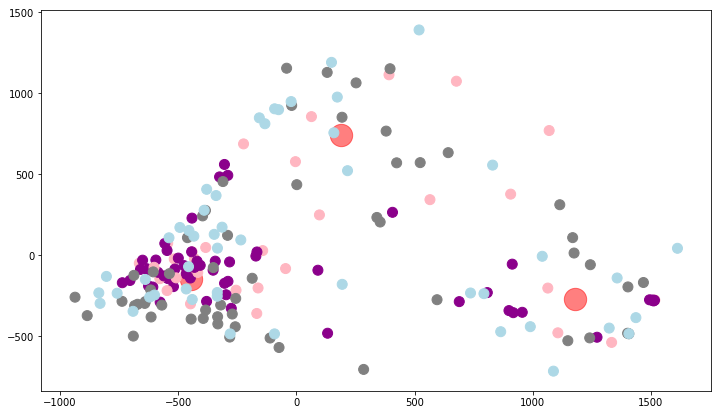

In [307]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(reduced_disseases[:, 0], reduced_disseases[:, 1], c=[colors[i] for i in y], s=100)

In [284]:
from sklearn.metrics import homogeneity_completeness_v_measure

In [283]:
homogeneity_completeness_v_measure(y, kmeans.labels_)

(0.021014696531589234, 0.024307127572864903, 0.022541321740321568)